**The Client**

XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

**Project delivery:**

You have been provided with multiple data sets that contains information on 2 cab companies. Each file (data set) provided represents different aspects of the customer profile. XYZ is interested in using your actionable insights to help them identify the right company to make their investment.

The outcome of your delivery will be a presentation to XYZ’s Executive team. This presentation will be judged based on the visuals provided, the quality of your analysis and the value of your recommendations and insights. 

**Data Set:**

You have been provided 4 individual data sets. Time period of data is from 31/01/2016 to 31/12/2018.

Below are the list of datasets which are provided for the analysis:

Cab_Data.csv – this file includes details of transaction for 2 cab companies

Customer_ID.csv – this is a mapping table that contains a unique identifier which links the customer’s demographic details

Transaction_ID.csv – this is a mapping table that contains transaction to customer mapping and payment mode

City.csv – this file contains list of US cities, their population and number of cab users

You should fully investigate and understand each data set.

- Review the Source Documentation
- Understand the field names and data types
- Identify relationships across the files
- Field/feature transformations
- Determine which files should be joined versus which ones should be appended
- Create master data and explain the relationship
- Identify and remove duplicates
- Perform other analysis like NA value and outlier detection
 

**Whatever and how many slides you prepare(Be creative and come up with meaningful insight):**

The idea is to create a hypothesis, engage with the data, think critically, and use various analytical approaches to produce unique insights.

You are not limited to only utilizing the data you have been provided.

We encourage you to find third party data sets which correspond to the overall theme and geographical properties of the data provided.  For Example: you can leverage US holiday data/ weather data

Also, do research on overall cab industry in US and try to relate that with the trend in data

**Analysis**

**Create multiple hypothesis and investigate:**

**You will need to generate 5-7 hypothesis initially to investigate as some will not prove what you are expecting.**

**For Example: “Is there any seasonality in number of customers using the cab service?”**

Areas to investigate:

- Which company has maximum cab users at a particular time period?
- Does margin proportionally increase with increase in number of customers?
- What are the attributes of these customer segments?
**Although not required, we encourage you to document the process and findings**

- What is the business problem?
- What are the properties of the data provided (data intake report)
- What steps did you take in order to create an applicable data set?
- How did you prepare and perform your analysis?
- What type of analysis did you perform?
- Why did you choose to use certain analytical techniques over others?
- What were the results?
Prepare a presentation that summarizes your analysis and recommendations and identify which company is performing better and is a better investment opportunity for XYZ.

# 1. Importing Libraries and Datasets

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from IPython.display import display, HTML, Image

import seaborn as sns
from scipy import stats

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

# Configure display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
cab_data = pd.read_csv('Cab_Data.csv')
customer_data = pd.read_csv('Customer_ID.csv')
transaction_data = pd.read_csv('Transaction_ID.csv')
city_data = pd.read_csv('City.csv')

# 2. Exploratory Data Analysis (EDA)

### Function for printing data types, shape, no.of rows, no.of columns, no. of missing values, information about the dataset

In [3]:
def display_dataframe_info(df, num_rows=5):
    print("*************************************Data Shape****************************************************")
    print(f"Number of Rows: {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")

    print("**************************************Data Type***************************************************")
    print(df.dtypes)
    
    print(f"\n********************************************** First {num_rows} Rows **********************************************")
    print(df.head(num_rows))

    print(f"\n********************************************** Last {num_rows} Rows **********************************************")
    print(df.tail(num_rows))

    print("\n********************************************** Missing Values **********************************************")
    print(df.isna().sum())

    print("\n********************************************** Descriptive Statistics **********************************************")
    print(df.describe().transpose())

### Function for identifying duplicates and deleting the rows and columns


In [4]:
def identify_duplicates(df):
    duplicate_rows = df[df.duplicated()]
    if duplicate_rows.empty:
        print("The DataFrame contains no duplicate rows.")
    else:
        print(f"There are {duplicate_rows.shape[0]} duplicate rows in the DataFrame.")
        print("Here are the duplicate rows:")
        print(duplicate_rows)

In [21]:
def extract_column_types(df, cat_threshold=10, car_threshold=20):
    # Identify categorical columns
    categorical_columns = [column for column in df.columns if df[column].dtype == "object"]
    
    # Identify numerical columns with categorical characteristics
    numeric_as_categorical = [column for column in df.columns if df[column].nunique() < cat_threshold and df[column].dtype != "object"]
    
    # Identify categorical columns with high cardinality
    categorical_high_cardinality = [column for column in df.columns if df[column].nunique() >= car_threshold and df[column].dtype == "object"]
    
    # Combine categorical columns with numerical-as-categorical columns
    categorical_columns = categorical_columns + numeric_as_categorical
    
    # Exclude high cardinality columns from categorical columns
    categorical_columns = [column for column in categorical_columns if column not in categorical_high_cardinality]
    
    # Identify numerical columns
    numerical_columns = [column for column in df.columns if df[column].dtype != "object"]
    
    # Exclude numerical columns with categorical characteristics
    numerical_columns = [column for column in numerical_columns if column not in numeric_as_categorical]

    print(f"Total Observations: {df.shape[0]}")
    print(f"Total Variables: {df.shape[1]}")
    print(f"Categorical Columns: {len(categorical_columns)}")
    print(f"Numerical Columns: {len(numerical_columns)}")
    print(f"High Cardinality Categorical Columns: {len(categorical_high_cardinality)}")
    print(f"Numerical Columns as Categorical: {len(numeric_as_categorical)}")
    
    return categorical_columns, numerical_columns, categorical_high_cardinality

In [6]:
def summarize_categorical(df, column, visualize=True):
    counts = df[column].value_counts()
    percentages = 100 * counts / len(df)
    
    summary_df = pd.DataFrame({column: counts.index, 'Counts': counts.values, 'Percentage': percentages.values})
    print(summary_df)

    if visualize:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette="viridis")
        plt.title(f'Distribution of {column}', fontsize=15)
        plt.xlabel('Counts', fontsize=12)
        plt.ylabel(column, fontsize=12)
        
        for i, (count, percent) in enumerate(zip(counts.values, percentages.values)):
            plt.text(count + 1, i, f'{count} ({percent:.2f}%)', va='center', fontsize=10)
        
        plt.show()

In [7]:
import matplotlib.pyplot as plt

def analyze_numerical(df, numeric_column, visualize=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary_stats = df[numeric_column].describe(percentiles=quantiles)
    
    print("Summary Statistics:")
    print(summary_stats)
    
    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(18, 4))
        
        # Histogram plot
        df[numeric_column].hist(bins=20, ax=axs[0], color="skyblue", edgecolor="black")
        axs[0].set_xlabel(numeric_column)
        axs[0].set_title(f'Histogram of {numeric_column}')
        
        # Summary statistics text display
        stats_text = "\n".join([f'{stat}: {value:.3f}' for stat, value in summary_stats.items()])
        axs[1].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center', horizontalalignment='left', linespacing=1.5)
        axs[1].axis('off')
        
        plt.show()

In [8]:
def calculate_outlier_bounds(df, column, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    iqr = upper_bound - lower_bound
    upper_limit = upper_bound + 1.5 * iqr
    lower_limit = lower_bound - 1.5 * iqr
    return lower_limit, upper_limit

def detect_outliers(df, column):
    lower_limit, upper_limit = calculate_outlier_bounds(df, column)
    outliers_exist = df[(df[column] > upper_limit) | (df[column] < lower_limit)].any(axis=None)
    return outliers_exist

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>cab_data DataFrame Analysis</h3>
</div>

In [9]:
 display_dataframe_info(cab_data)

*************************************Data Shape****************************************************
Number of Rows: 359392
Number of Columns: 7
**************************************Data Type***************************************************
Transaction ID      int64
Date of Travel      int64
Company            object
City               object
KM Travelled      float64
Price Charged     float64
Cost of Trip      float64
dtype: object

********************************************** First 5 Rows **********************************************
   Transaction ID  Date of Travel   Company        City  KM Travelled  Price Charged  Cost of Trip
0        10000011           42377  Pink Cab  ATLANTA GA        30.450        370.950       313.635
1        10000012           42375  Pink Cab  ATLANTA GA        28.620        358.520       334.854
2        10000013           42371  Pink Cab  ATLANTA GA         9.040        125.200        97.632
3        10000014           42376  Pink Cab  ATLANTA GA  

In [10]:
identify_duplicates(cab_data)

The DataFrame contains no duplicate rows.


In [11]:
cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], origin='1899-12-30', unit='D')
cab_data['Date of Travel'] = cab_data['Date of Travel'].dt.date

In [12]:
cab_data['Transaction ID'] = cab_data['Transaction ID'].astype(str)

In [13]:
cab_data.columns = cab_data.columns.str.replace(' ', '_')

In [14]:
cab_data.head()

Transaction_ID Date_of_Travel   Company        City  KM_Travelled  Price_Charged  Cost_of_Trip
0       10000011     2016-01-08  Pink Cab  ATLANTA GA        30.450        370.950       313.635
1       10000012     2016-01-06  Pink Cab  ATLANTA GA        28.620        358.520       334.854
2       10000013     2016-01-02  Pink Cab  ATLANTA GA         9.040        125.200        97.632
3       10000014     2016-01-07  Pink Cab  ATLANTA GA        33.170        377.400       351.602
4       10000015     2016-01-03  Pink Cab  ATLANTA GA         8.730        114.620        97.776

- **The data type of the "Date of Travel" and "Transaction ID" columns needs to be modified.**

- **The dataframe includes details on 359,392 travel transactions.**

- **There are no missing values in the dataset.**

- **The average distance traveled is 22.567 kilometers, and the average price charged is $423.443.**

- **The mean cost of a trip is approximately 286 dollars.**

Total Observations: 359392
Total Variables: 7
Categorical Columns: 2
Numerical Columns: 3
High Cardinality Categorical Columns: 2
Numerical Columns as Categorical: 0
['Company', 'City'] ['KM_Travelled', 'Price_Charged', 'Cost_of_Trip'] ['Transaction_ID', 'Date_of_Travel']
      Company  Counts  Percentage
0  Yellow Cab  274681      76.429
1    Pink Cab   84711      23.571


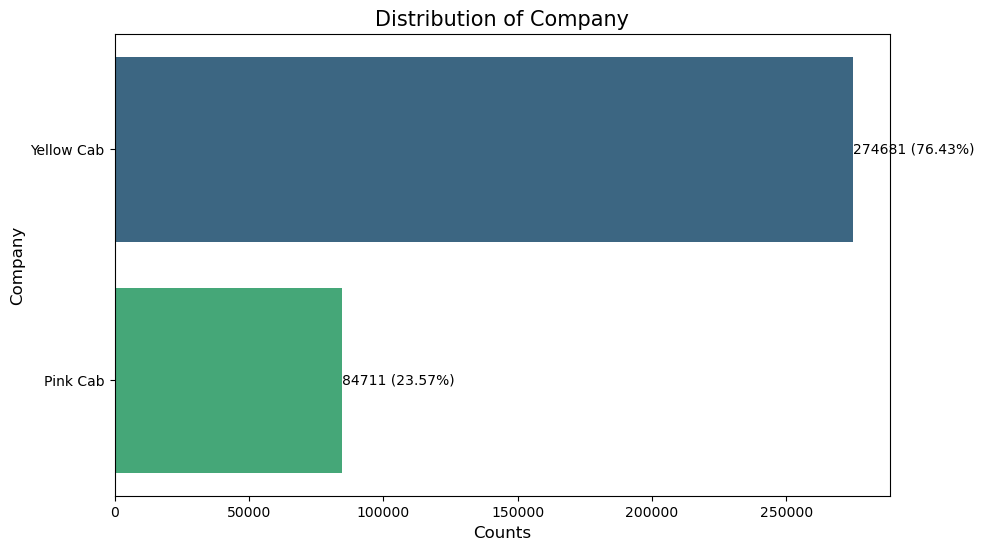

              City  Counts  Percentage
0      NEW YORK NY   99885      27.793
1       CHICAGO IL   56625      15.756
2   LOS ANGELES CA   48033      13.365
3    WASHINGTON DC   43737      12.170
4        BOSTON MA   29692       8.262
5     SAN DIEGO CA   20488       5.701
6   SILICON VALLEY    8519       2.370
7       SEATTLE WA    7997       2.225
8       ATLANTA GA    7557       2.103
9        DALLAS TX    7017       1.952
10        MIAMI FL    6454       1.796
11       AUSTIN TX    4896       1.362
12   ORANGE COUNTY    3982       1.108
13       DENVER CO    3825       1.064
14    NASHVILLE TN    3010       0.838
15   SACRAMENTO CA    2367       0.659
16      PHOENIX AZ    2064       0.574
17       TUCSON AZ    1931       0.537
18   PITTSBURGH PA    1313       0.365


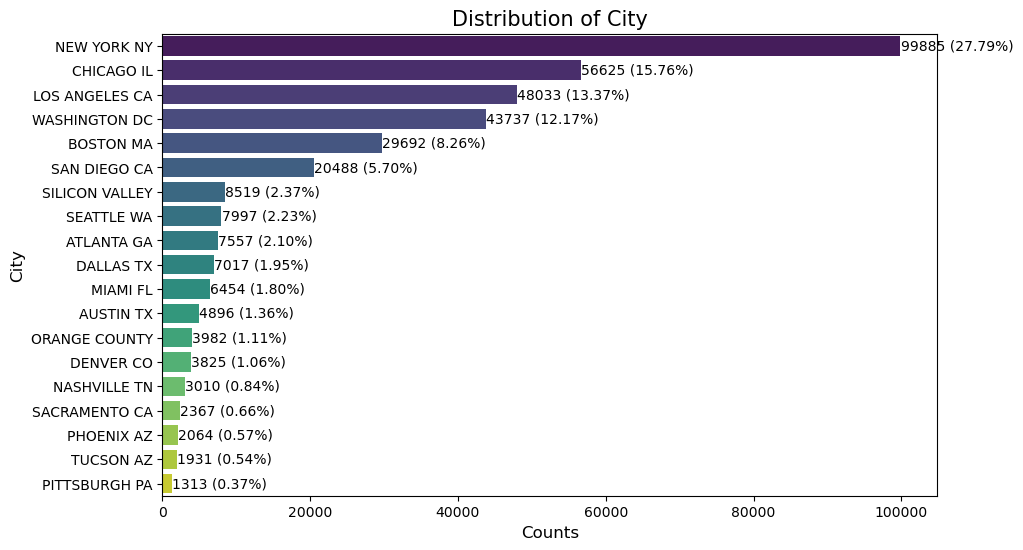

In [15]:
# Extracting numerical and categorical columns
categorical_cols, numerical_cols, high_cardinality_cats = extract_column_types(cab_data) 
print(categorical_cols, numerical_cols, high_cardinality_cats)

# Analyzing and visualizing categorical variables
for col in categorical_cols:
    summarize_categorical(cab_data, col, visualize=True)

- The Yellow Cab company leads with 76.43% of the operations, while the Pink Cab company represents 23.57%. This clearly shows Yellow Cab's significant advantage.

- In terms of cities, NEW YORK, CHICAGO, and LOS ANGELES have the highest number of transactions.

Summary Statistics:
count   359392.000
mean        22.567
std         12.234
min          1.900
5%           3.570
10%          5.800
20%          9.900
30%         14.140
40%         18.240
50%         22.440
60%         26.600
70%         30.780
80%         34.980
90%         39.200
95%         42.000
99%         45.630
max         48.000
Name: KM_Travelled, dtype: float64


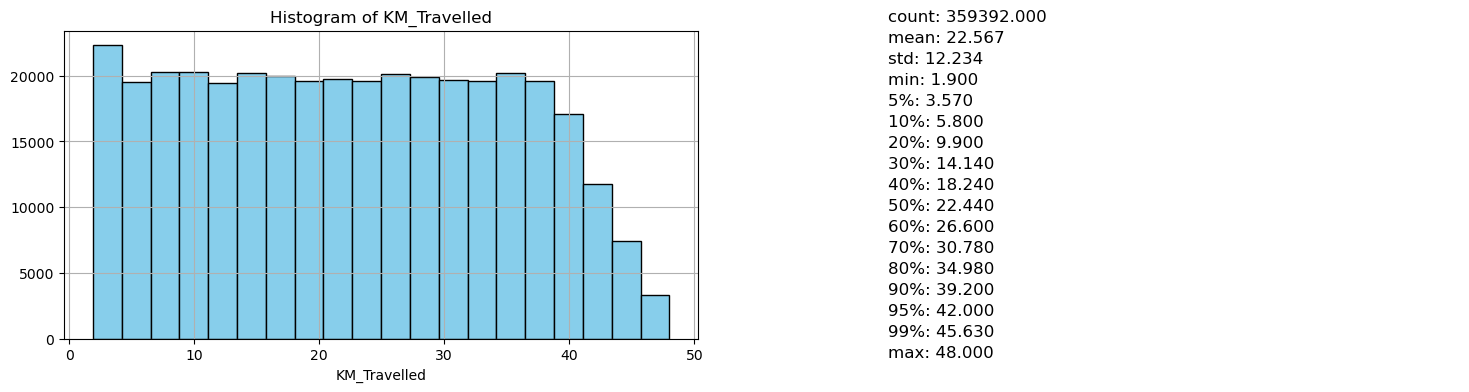

Summary Statistics:
count   359392.000
mean       423.443
std        274.379
min         15.600
5%          63.420
10%         99.231
20%        170.970
30%        242.270
40%        314.054
50%        386.360
60%        460.150
70%        538.830
80%        635.680
90%        792.790
95%        944.890
99%       1230.109
max       2048.030
Name: Price_Charged, dtype: float64


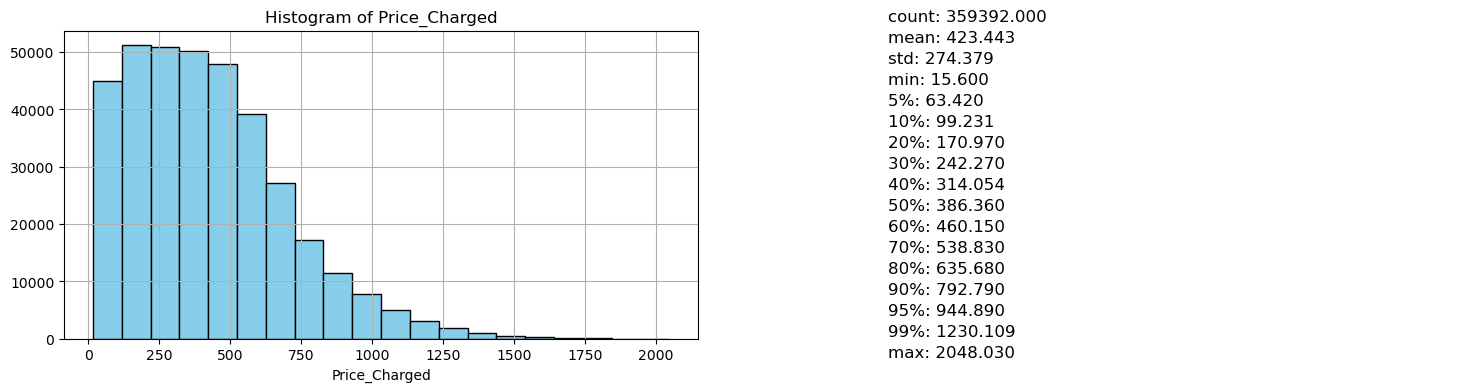

Summary Statistics:
count   359392.000
mean       286.190
std        157.994
min         19.000
5%          46.224
10%         72.576
20%        124.762
30%        177.293
40%        229.680
50%        282.480
60%        334.254
70%        387.115
80%        440.429
90%        502.501
95%        544.363
99%        610.560
max        691.200
Name: Cost_of_Trip, dtype: float64


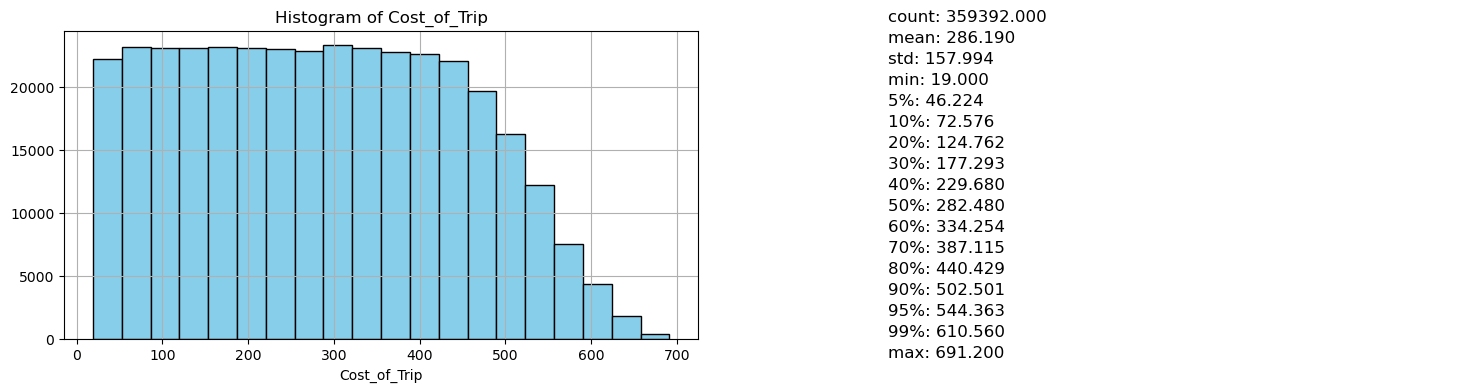

KM_Travelled False
Price_Charged True
Cost_of_Trip False


In [16]:
for col in numerical_cols:
    analyze_numerical(cab_data, col, visualize=True) 

for col in numerical_cols:
    print(col, detect_outliers(cab_data, col))

- The graph shows that the shortest distance traveled is 1.9 km, and the longest is 48 km.

- Examining the Price_Charged variable reveals a lack of normal distribution, likely due to outliers, with a maximum value of around 2048 and a median value of about 386.

- The minimum trip cost is 19 dollars, while the maximum is approximately 691 dollars.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>customer_data DataFrame Analysis</h3>
</div>

- **The average customer age is about 35 years.**
- **Customers have an average monthly income of roughly 15,000 dollars.**
- **The dataset contains no missing values.**
- **The data type of the "Customer ID" column needs to be changed.**

In [17]:
display_dataframe_info(customer_data)

*************************************Data Shape****************************************************
Number of Rows: 49171
Number of Columns: 4
**************************************Data Type***************************************************
Customer ID            int64
Gender                object
Age                    int64
Income (USD/Month)     int64
dtype: object

********************************************** First 5 Rows **********************************************
   Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237
2        28712   Male   53               11242
3        28020   Male   23               23327
4        27182   Male   33                8536

********************************************** Last 5 Rows **********************************************
       Customer ID  Gender  Age  Income (USD/Month)
49166        12490    Male   33               18713
49167        14971    Male 

The DataFrame contains no duplicate rows.
  Customer_ID Gender  Age  Income_(USD/Month)
0       29290   Male   28               10813
1       27703   Male   27                9237
2       28712   Male   53               11242
3       28020   Male   23               23327
4       27182   Male   33                8536
Total Observations: 49171
Total Variables: 4
Categorical Columns: 1
Numerical Columns: 2
High Cardinality Categorical Columns: 1
Numerical Columns as Categorical: 0
['Gender'] ['Age', 'Income_(USD/Month)'] ['Customer_ID']
   Gender  Counts  Percentage
0    Male   26562      54.020
1  Female   22609      45.980


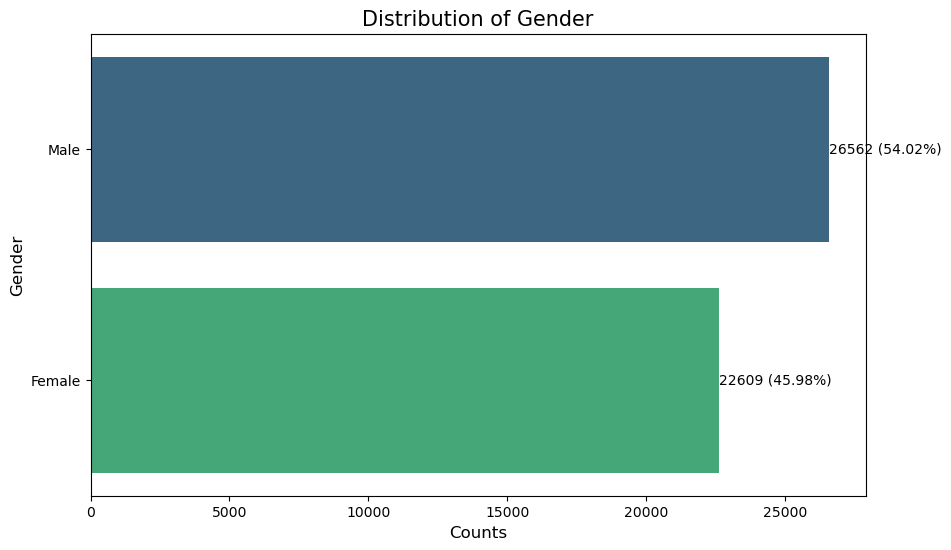

In [22]:
# Checking for duplicates
identify_duplicates(customer_data)

# Remove duplicate columns by keeping the first occurrence
customer_data = customer_data.loc[:, ~customer_data.columns.duplicated()]

# Changing the type of Customer ID datatype
customer_data['Customer_ID'] = customer_data['Customer_ID'].astype(str)
customer_data.columns = customer_data.columns.str.replace(' ', '_')

# Displaying the first few rows of the dataframe
print(customer_data.head())

# Capturing numerical and categorical variables
categorical_cols, numerical_cols, high_cardinality_cats = extract_column_types(customer_data)
print(categorical_cols, numerical_cols, high_cardinality_cats)

# Analysis of categorical variables
for col in categorical_cols:
    summarize_categorical(customer_data, col, visualize=True)

Upon examining the gender distribution of customers, it is noted that male customers constitute approximately 54%, whereas female customers represent about 46%.

Summary Statistics:
count   49171.000
mean       35.363
std        12.599
min        18.000
5%         19.000
10%        21.000
20%        24.000
30%        27.000
40%        30.000
50%        33.000
60%        36.000
70%        39.000
80%        47.000
90%        56.000
95%        61.000
99%        64.300
max        65.000
Name: Age, dtype: float64


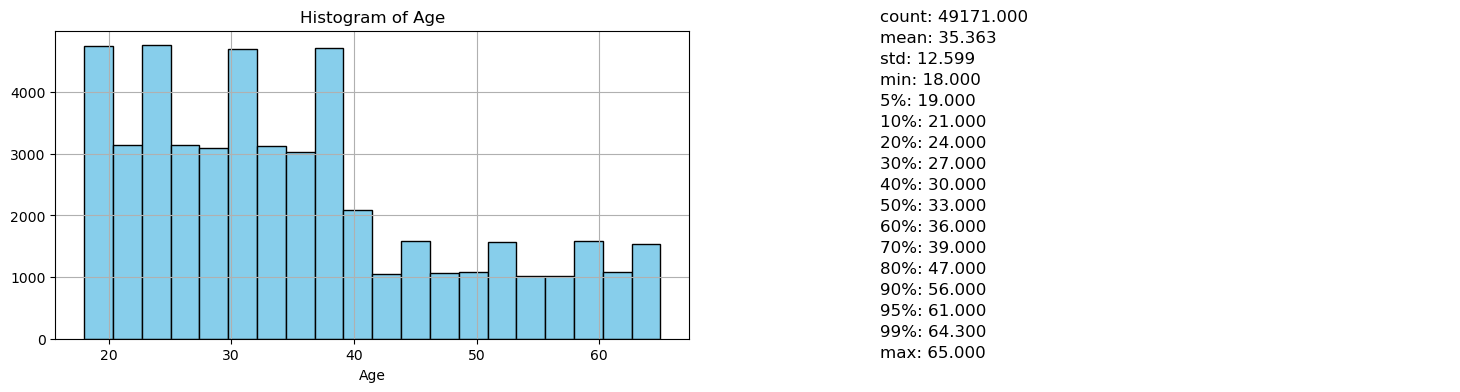

Summary Statistics:
count   49171.000
mean    15015.632
std      8002.208
min      2000.000
5%       3235.000
10%      4496.000
20%      7022.000
30%      9547.000
40%     12137.000
50%     14656.000
60%     17194.000
70%     19754.000
80%     22314.000
90%     24798.000
95%     29645.000
99%     33956.600
max     35000.000
Name: Income_(USD/Month), dtype: float64


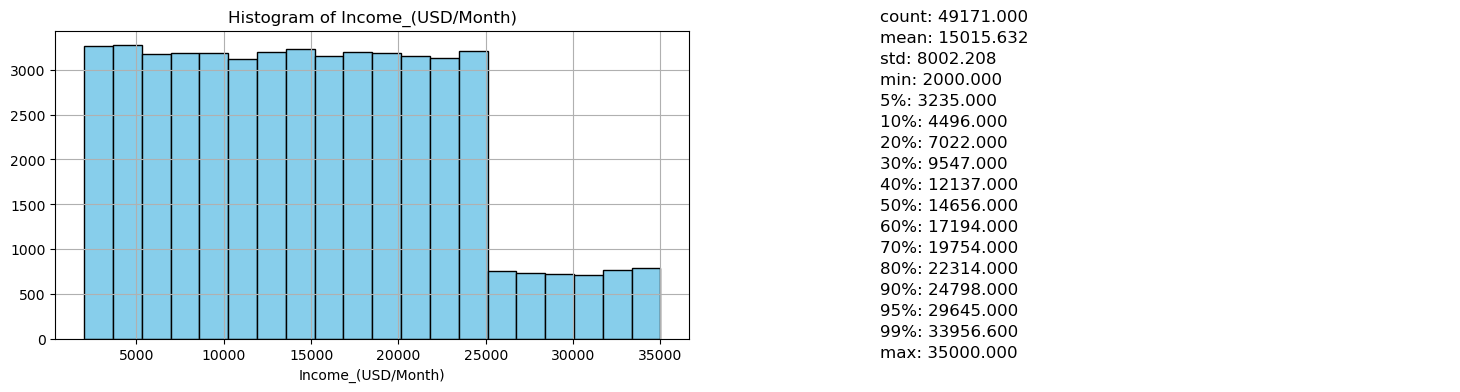

Age: No Outliers
Income_(USD/Month): No Outliers


In [23]:
for column in numerical_cols:
    analyze_numerical(customer_data, column, visualize=True)

# Outlier Detection

for column in numerical_cols:
    outliers_present = detect_outliers(customer_data, column)
    print(f"{column}: {'Outliers Detected' if outliers_present else 'No Outliers'}")

- There are no outliers in this dataset.

- More than 70% of customers are below the age of 40.
- Around 10% of customers have a monthly income exceeding $25,000.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>transaction_data DataFrame Analysis</h3>
</div>

In [24]:
display_dataframe_info(transaction_data)

*************************************Data Shape****************************************************
Number of Rows: 440098
Number of Columns: 3
**************************************Data Type***************************************************
Transaction ID     int64
Customer ID        int64
Payment_Mode      object
dtype: object

********************************************** First 5 Rows **********************************************
   Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card
2        10000013        28712         Cash
3        10000014        28020         Cash
4        10000015        27182         Card

********************************************** Last 5 Rows **********************************************
        Transaction ID  Customer ID Payment_Mode
440093        10440104        53286         Cash
440094        10440105        52265         Cash
440095        10440106        52175       

- **There is no missing values and then we need to change the type of type of "Transaction ID" and "Customer ID" columns.**

The DataFrame contains no duplicate rows.
Column names: Index(['Transaction ID', 'Customer ID', 'Payment_Mode'], dtype='object')
Correct Transaction ID column: Transaction ID
Correct Customer ID column: Customer ID
Column names after replacement: Index(['Transaction_ID', 'Customer_ID', 'Payment_Mode'], dtype='object')
  Transaction_ID Customer_ID Payment_Mode
0       10000011       29290         Card
1       10000012       27703         Card
2       10000013       28712         Cash
3       10000014       28020         Cash
4       10000015       27182         Card
Total Observations: 440098
Total Variables: 3
Categorical Columns: 1
Numerical Columns: 0
High Cardinality Categorical Columns: 2
Numerical Columns as Categorical: 0
['Payment_Mode'] [] ['Transaction_ID', 'Customer_ID']
  Payment_Mode  Counts  Percentage
0         Card  263991      59.985
1         Cash  176107      40.015


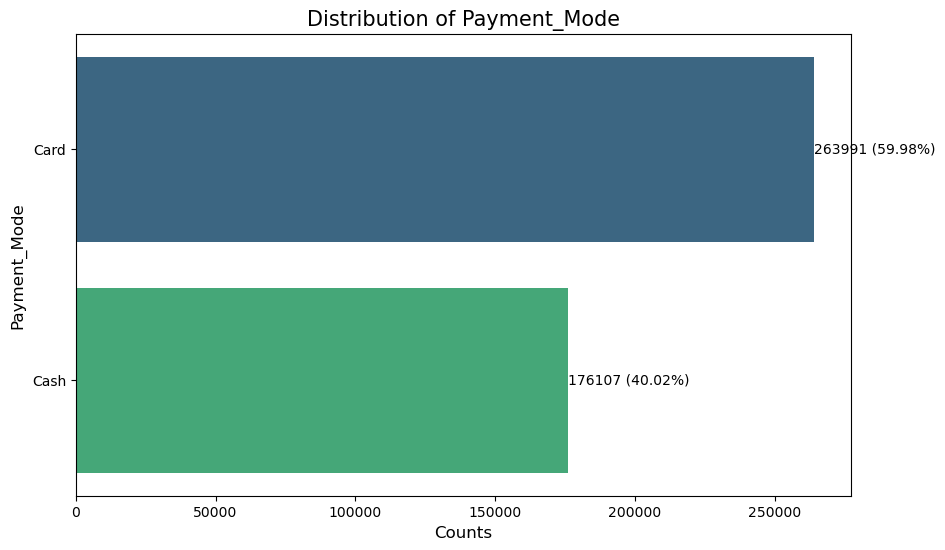

In [28]:
# Checking for duplicates
identify_duplicates(transaction_data)

# Print column names to identify correct names
print("Column names:", transaction_data.columns)

# Assuming the correct column names from the print statement, update these variables
correct_transaction_id_column = 'Transaction ID'  # Replace this with the exact column name if different
correct_customer_id_column = 'Customer ID'  # Replace this with the exact column name if different

# Debug: Print the exact column names before processing
print("Correct Transaction ID column:", correct_transaction_id_column)
print("Correct Customer ID column:", correct_customer_id_column)

# Converting 'Transaction ID' and 'Customer ID' to string type
transaction_data[correct_transaction_id_column] = transaction_data[correct_transaction_id_column].astype(str)
transaction_data[correct_customer_id_column] = transaction_data[correct_customer_id_column].astype(str)

# Replacing spaces with underscores in column names
transaction_data.columns = transaction_data.columns.str.replace(' ', '_')

# Debug: Print column names after replacing spaces with underscores
print("Column names after replacement:", transaction_data.columns)

# Display the first few rows of the dataframe
print(transaction_data.head())

# Capturing numerical and categorical variables
categorical_cols, numerical_cols, high_cardinality_cats = extract_column_types(transaction_data)
print(categorical_cols, numerical_cols, high_cardinality_cats)

# Analysis of categorical variables
for column in categorical_cols:
    summarize_categorical(transaction_data, column, visualize=True)

- When we examine the graph, we observe that nearly 60% of the transactions have been made using a card.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>city_data DataFrame Analysis</h3>
</div>

In [29]:
display_dataframe_info(city_data)

*************************************Data Shape****************************************************
Number of Rows: 20
Number of Columns: 3
**************************************Data Type***************************************************
City          object
Population    object
Users         object
dtype: object

********************************************** First 5 Rows **********************************************
             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 

********************************************** Last 5 Rows **********************************************
             City Population      Users
15  SACRAMENTO CA   545,776      7,044 
16  PITTSBURGH PA   542,085      3,643 
17  WASHINGTON DC   418,859    127,001 
18   NASHVILLE TN   327,225      9,270 
19      BOSTON MA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        20 non-null     object 
 1   Population  20 non-null     float64
 2   Users       20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes
None
The DataFrame contains no duplicate rows.
Total Observations: 20
Total Variables: 3
Categorical Columns: 0
Numerical Columns: 2
High Cardinality Categorical Columns: 1
Numerical Columns as Categorical: 0
['Population', 'Users'] ['City']
Summary Statistics:
count        20.000
mean    1231592.000
std     1740126.700
min      248968.000
5%       323312.150
10%      409695.600
20%      545037.800
30%      630886.700
40%      687517.800
50%      784559.000
60%      943344.400
70%      980570.400
80%     1209918.200
90%     1631046.300
95%     2277665.350
99%     7180202.670
max     8405837.000
Name: Population, dtype: float64


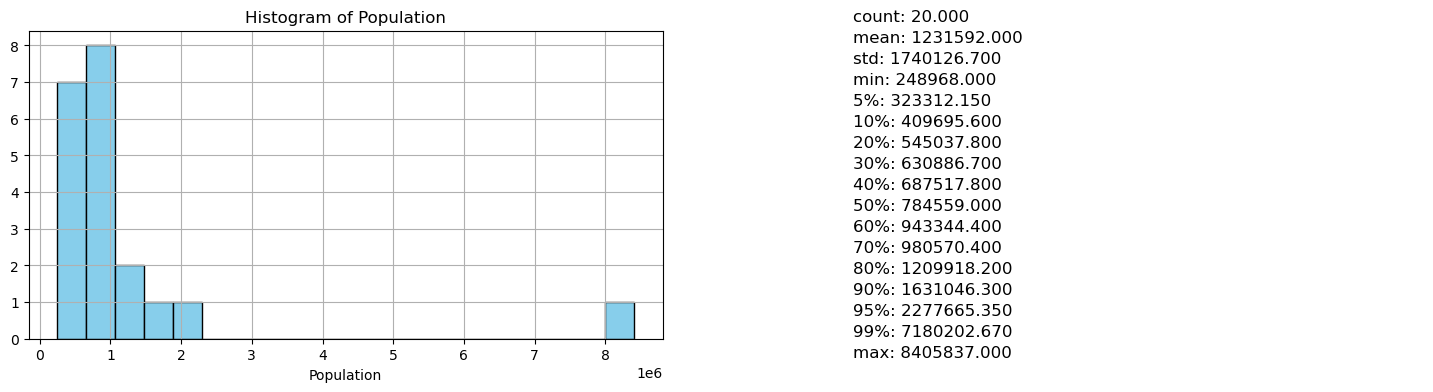

Summary Statistics:
count       20.000
mean     64520.650
std      83499.375
min       3643.000
5%        5608.550
10%       6090.900
20%       8824.800
30%      12822.100
40%      16596.200
50%      23429.000
60%      25936.600
70%      73002.800
80%     130427.200
90%     169382.100
95%     218036.000
99%     285326.400
max     302149.000
Name: Users, dtype: float64


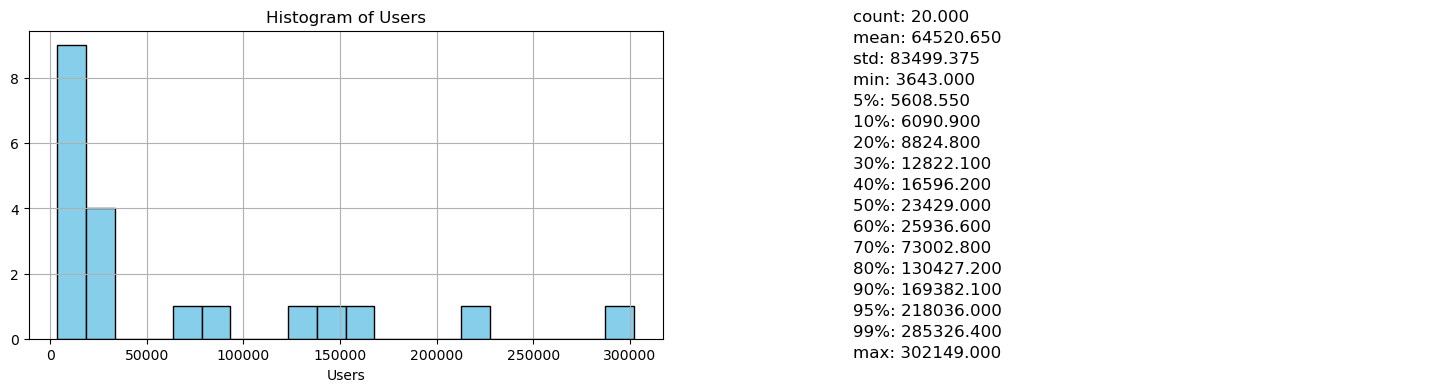

Population: Outliers Detected
Users: No Outliers


In [30]:
# Removing commas and converting columns to float
city_data['Population'] = city_data['Population'].str.replace(',', '').astype(float)
city_data['Users'] = city_data['Users'].str.replace(',', '').astype(float)

# Displaying the data types and other information about the DataFrame
print(city_data.info())

# Checking for duplicates
identify_duplicates(city_data)

# Capturing numerical and categorical variables
categorical_cols, numerical_cols, high_cardinality_cats = extract_column_types(city_data)
print(numerical_cols, high_cardinality_cats)

# Analysis of Numerical Variables
for column in numerical_cols:
    analyze_numerical(city_data, column, visualize=True) 

# Outlier Detection
for column in numerical_cols:
    outliers_present = detect_outliers(city_data, column)
    print(f"{column}: {'Outliers Detected' if outliers_present else 'No Outliers'}")

- Observing the graph reveals that the city with the smallest population has about 250,000 residents, while the city with the largest population totals around 8.5 million.

- The number of users across cities where taxi companies operate ranges from a minimum of 3,643 to a maximum of 302,149.

- This dataset includes outlier values in the "Population" data, but I chose not to handle these outliers.

# 3. Merging the Dataset

In [31]:
# Merging cab_data and transaction_data datasets
merged_cab_transaction = pd.merge(cab_data, transaction_data, on="Transaction_ID")
print(merged_cab_transaction.head(3))
print("***********************************************************************************")

# Merging customer_data and merged_cab_transaction datasets
merged_customer_cab_transaction = pd.merge(merged_cab_transaction, customer_data, on="Customer_ID")
print(merged_customer_cab_transaction.head(3))
print("***********************************************************************************")

# Merging the combined dataset with city_data
final_merged_df = pd.merge(merged_customer_cab_transaction, city_data, on="City")
print(final_merged_df.head(3))
print("***********************************************************************************")

# Displaying the shape of the final merged DataFrame
print(final_merged_df.shape)

  Transaction_ID Date_of_Travel   Company        City  KM_Travelled  Price_Charged  Cost_of_Trip Customer_ID Payment_Mode
0       10000011     2016-01-08  Pink Cab  ATLANTA GA        30.450        370.950       313.635       29290         Card
1       10000012     2016-01-06  Pink Cab  ATLANTA GA        28.620        358.520       334.854       27703         Card
2       10000013     2016-01-02  Pink Cab  ATLANTA GA         9.040        125.200        97.632       28712         Cash
***********************************************************************************
  Transaction_ID Date_of_Travel     Company        City  KM_Travelled  Price_Charged  Cost_of_Trip Customer_ID Payment_Mode Gender  Age  Income_(USD/Month)
0       10000011     2016-01-08    Pink Cab  ATLANTA GA        30.450        370.950       313.635       29290         Card   Male   28               10813
1       10351127     2018-07-21  Yellow Cab  ATLANTA GA        26.190        598.700       317.423       29290      

### Correlation Analysis

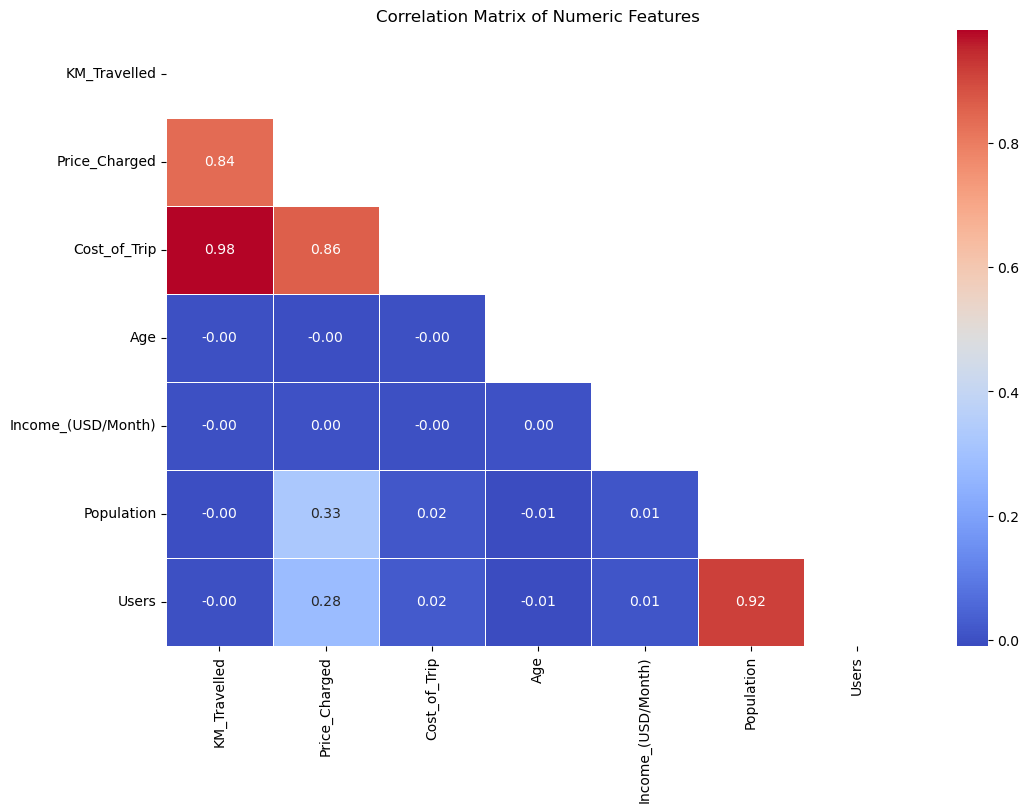

In [32]:
numeric_columns = final_merged_df.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=mask)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

- **There is a strong correlation between <span style="background-color: gray; padding: 2px 4px; color: white;">Population</span> and <span style="background-color: gray; padding: 2px 4px; color: white;">Users</span> based on observations.**
- **Moreover, there is a significant correlation among <span style="background-color: gray; padding: 2px 4px; color: white;">Price_Charged</span>, <span style="background-color: gray; padding: 2px 4px; color: white;">Cost_of_Trip</span>, and <span style="background-color: gray; padding: 2px 4px; color: white;">KM_Travelled</span>.**

# 4. Comprehensive Analysis of the Whole Dataset

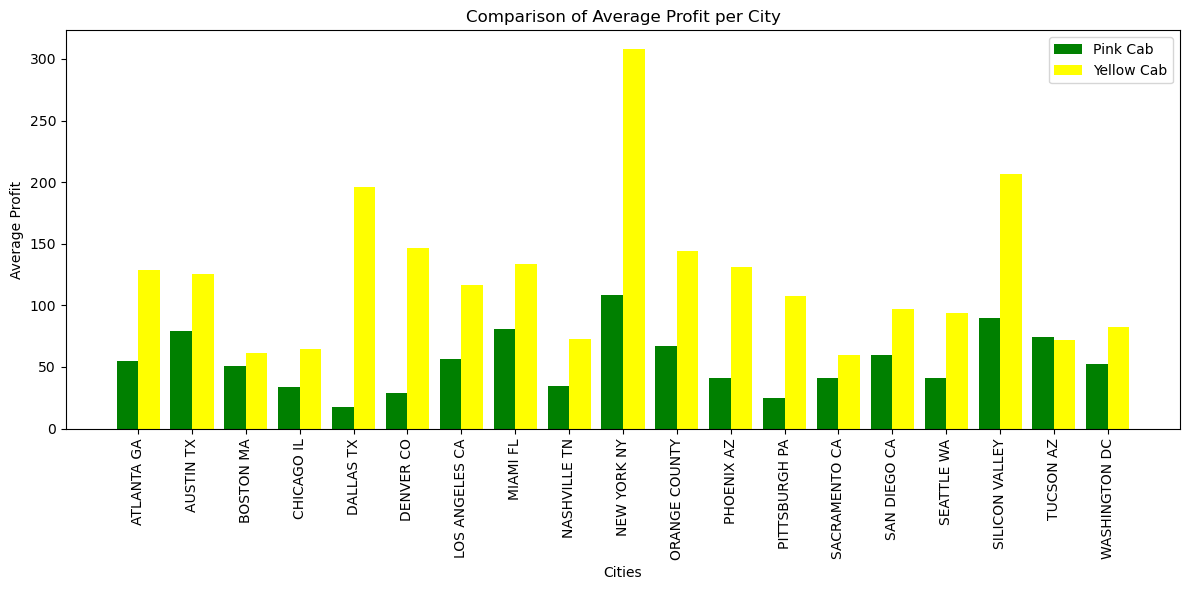

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Creating a duplicate of the DataFrame
df_copy = final_merged_df.copy()

# Calculating profit for each trip
df_copy['Profit'] = df_copy['Price_Charged'] - df_copy['Cost_of_Trip']

# Calculating average profit per city for Pink Cab and Yellow Cab
average_profit_per_city = df_copy.groupby(['City', 'Company'])['Profit'].mean().unstack()

# Generating the bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
positions = np.arange(len(average_profit_per_city.index))

plt.bar(positions, average_profit_per_city['Pink Cab'], bar_width, label='Pink Cab', color='green')
plt.bar(positions + bar_width, average_profit_per_city['Yellow Cab'], bar_width, label='Yellow Cab', color='yellow')

plt.xticks(positions + bar_width / 2, average_profit_per_city.index, rotation=90)
plt.xlabel('Cities')
plt.ylabel('Average Profit')
plt.title('Comparison of Average Profit per City')
plt.legend()

plt.tight_layout()
plt.show()

In every city except Tucson, AZ, Yellow Cab's average profit surpasses that of Pink Cab.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Payment Mode Comparison by Company</h3>
</div>

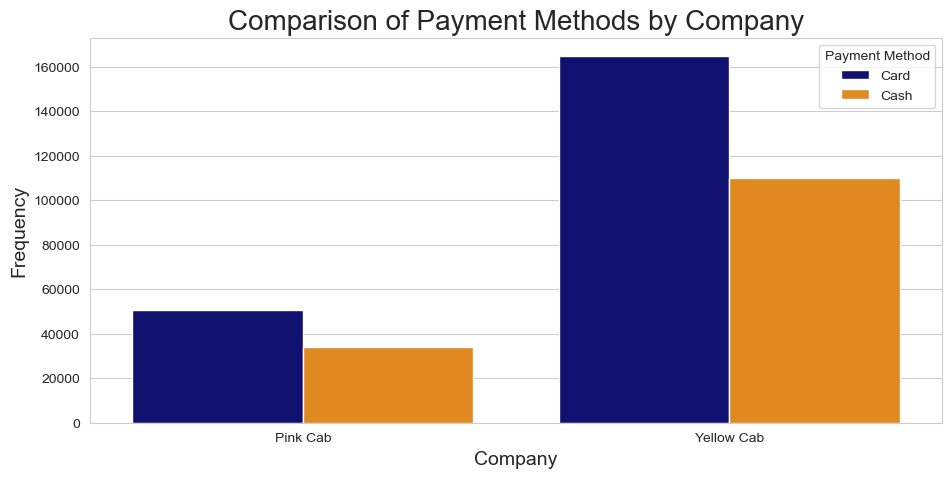

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the Seaborn style
sns.set_style("whitegrid")

# Creating the figure and axis
plt.figure(figsize=(11, 5))

# Plotting the count plot with Seaborn
sns.countplot(x="Company", hue="Payment_Mode", data = df_copy, palette={"Card": "navy", "Cash": "darkorange"})

# Setting the title and labels
plt.title('Comparison of Payment Methods by Company', fontsize=20)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding the legend
plt.legend(title="Payment Method")

# Displaying the plot
plt.show()

# Note

Text(0.5, 1.0, 'Age Distribution by Gender')

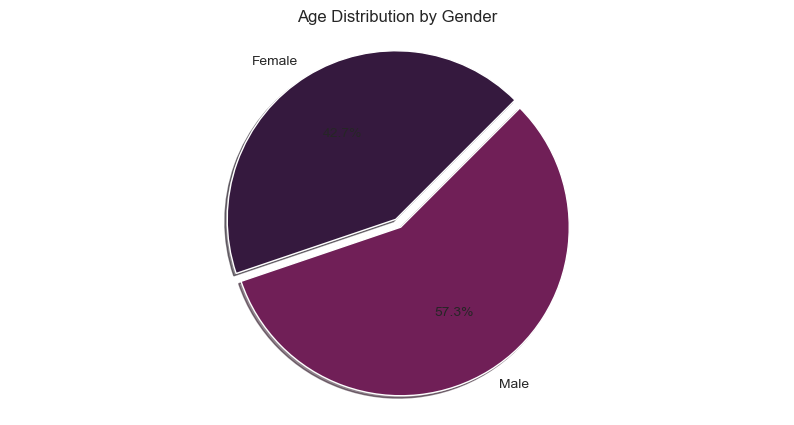

In [39]:
# Age Distribution by Gender
fig, ax = plt.subplots(figsize=(10, 5))
textprops = {"fontsize":10}
explodes = [0.1, 0.01]
group = final_merged_df.groupby(by=['Gender'])['Age'].count().reset_index()
ax.pie(data=group, x='Age', labels="Gender", colors=sns.color_palette("rocket"), radius=2, 
       explode=explodes, autopct='%1.1f%%', shadow=True, startangle=45, textprops=textprops)
ax.axis('equal')
ax.set_title("Age Distribution by Gender")

(-1.1086138142783537,
 1.125726968389288,
 -1.1264546495611691,
 1.2283546106264536)

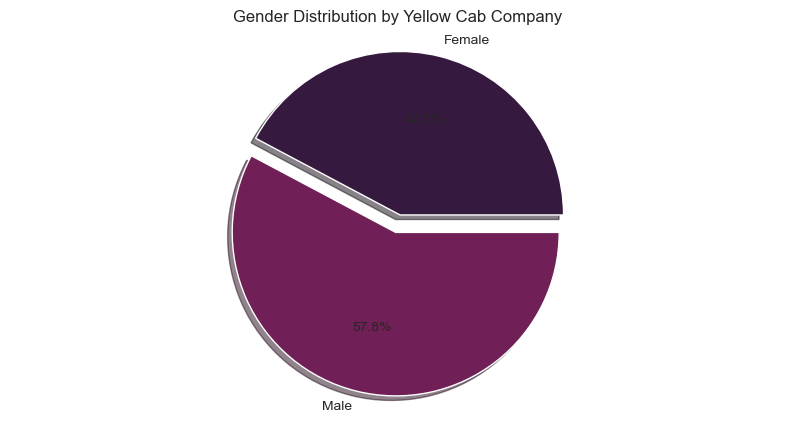

In [40]:
# Gender Distribution by Yellow Cab Company
fig, ax = plt.subplots(figsize=(10, 5))
data = final_merged_df[final_merged_df['Company'] == 'Yellow Cab']
group = data.groupby(by=['Gender'])['Age'].count().reset_index()
ax.pie(data=group, x='Age', labels="Gender", colors=sns.color_palette("rocket"), 
       explode=explodes, autopct='%1.1f%%', shadow=True, textprops=textprops)
ax.set_title("Gender Distribution by Yellow Cab Company", fontsize=12)
ax.axis('equal')

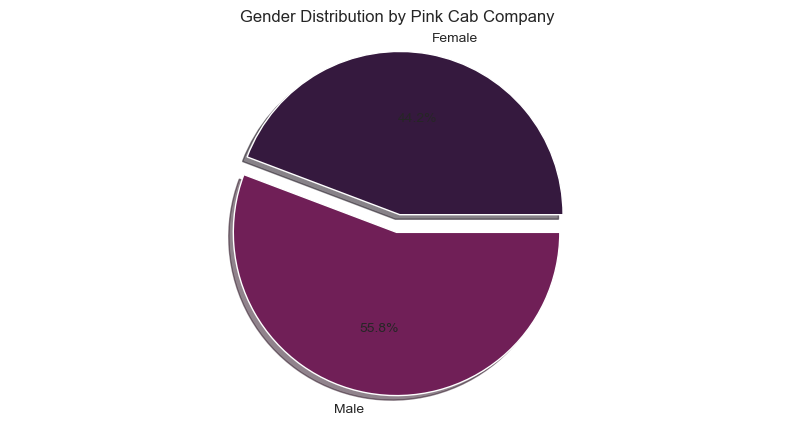

In [41]:
# Gender Distribution by Pink Cab Company
fig, ax = plt.subplots(figsize=(10, 5))
data = final_merged_df[final_merged_df['Company'] == 'Pink Cab']
group = data.groupby(by=['Gender'])['Age'].count().reset_index()
ax.pie(data=group, x='Age', labels="Gender", colors=sns.color_palette("rocket"), 
       explode=explodes, autopct='%1.1f%%', shadow=True, textprops=textprops)
ax.set_title("Gender Distribution by Pink Cab Company", fontsize=12)
ax.axis('equal')
plt.show()

In [43]:
import plotly.express as px
age_counts = final_merged_df['Age'].value_counts()
fig = px.bar(age_counts, title='Age Frequency for Company')
fig.update_layout(xaxis_title='Age', yaxis_title='Frequency', title_x=0.5, showlegend=False)
fig.show()

   Price_Charged  Cost_of_Trip  Profit
0        370.950       313.635  57.315
1        598.700       317.423 281.277
2        792.050       597.402 194.648
3        358.520       334.854  23.666
4        721.100       467.119 253.981


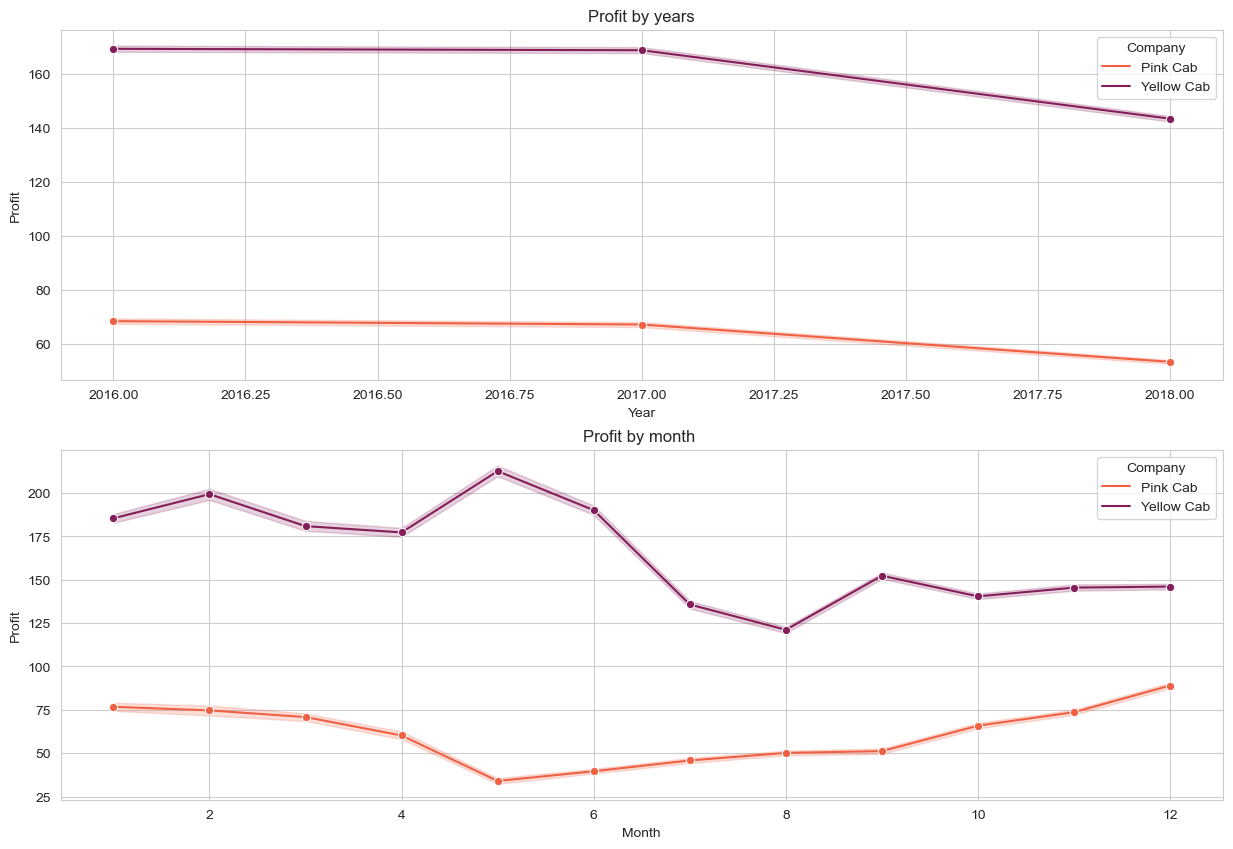

In [49]:
# Ensure the Profit column is present
final_merged_df['Profit'] = final_merged_df['Price_Charged'] - final_merged_df['Cost_of_Trip']

# Check if the Profit column is correctly calculated and present
print(final_merged_df[['Price_Charged', 'Cost_of_Trip', 'Profit']].head())

# Profit by Years and Months
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 1, 1)
final_merged_df["Year"] = pd.to_datetime(final_merged_df["Date_of_Travel"]).apply(lambda x: x.year)
plt.title("Profit by years")
ax = sns.lineplot(data=final_merged_df, x='Year', y='Profit', hue="Company", marker='o', palette="rocket_r")

fig.add_subplot(2, 1, 2)
final_merged_df["Month"] = pd.to_datetime(final_merged_df["Date_of_Travel"]).apply(lambda x: x.month)
plt.title("Profit by month ")
ax = sns.lineplot(data=final_merged_df, x='Month', y='Profit', hue="Company", marker='o', palette="rocket_r")

plt.show()

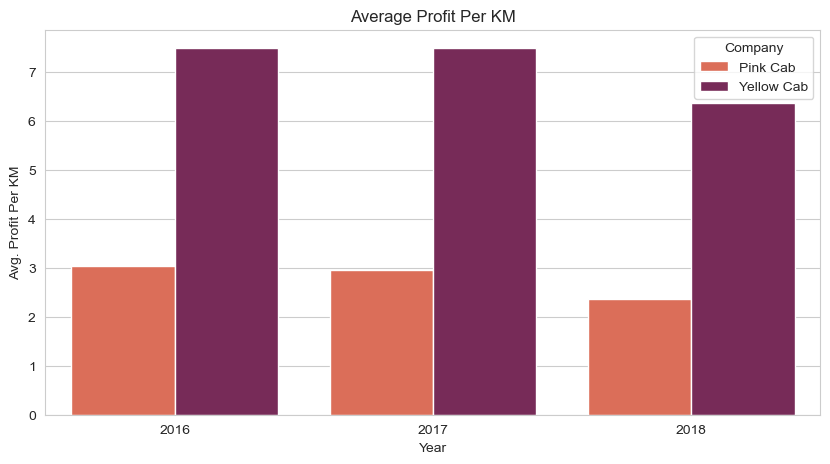

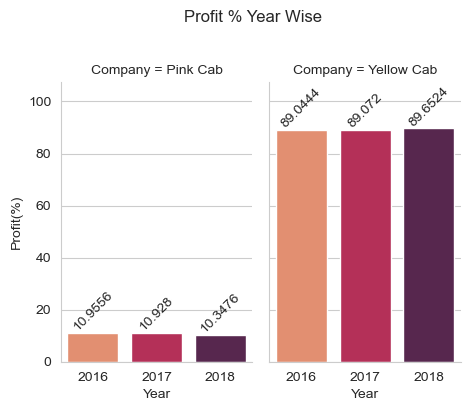

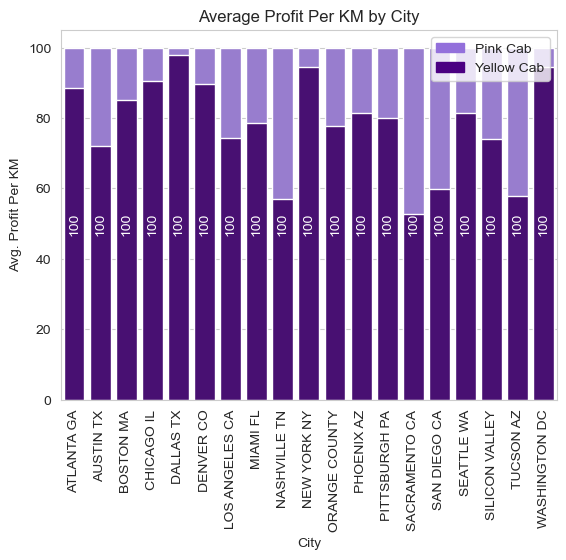

In [54]:
import matplotlib.patches as mpatches
final_merged_df['Profit'] = final_merged_df['Price_Charged'] - final_merged_df['Cost_of_Trip']

# Average Profit Per KM
profit = final_merged_df.groupby(['Company', 'Year'])['Profit'].sum().reset_index()
km = final_merged_df.groupby(['Company', 'Year'])['KM_Travelled'].sum().reset_index()
data1 = profit['Profit'] / km['KM_Travelled']
data1 = pd.DataFrame(data1)
data1.rename(columns={data1.columns[0]: 'Profit'}, inplace=True)
data1["Year"] = profit['Year']
data1["Company"] = profit['Company']
group = data1.groupby(['Company', 'Year'])['Profit'].sum().reset_index()

plt.figure(figsize=(10, 5))
group_by_year = data1.groupby(['Year', 'Company']).sum().reset_index()
sns.barplot(x="Year", y="Profit", hue="Company", data=group_by_year, palette="rocket_r")
plt.ylabel("Avg. Profit Per KM")
plt.title("Average Profit Per KM")
plt.show()

# Profit % Year Wise
data = final_merged_df.groupby(['Company', 'Year']).agg({'Profit': 'sum'}).groupby(level=1).apply(lambda x: 100 * x / float(x.sum())).reset_index()
bar = sns.catplot(data=data, x="Year", y="Profit", col_wrap=4, palette="rocket_r", col="Company", height=4, aspect=.8, kind="bar")
for ax in bar.axes.ravel(): 
    for c in ax.containers:
        ax.bar_label(c, label_type='edge', rotation=45)
    ax.margins(y=0.2)

bar.fig.subplots_adjust(top=0.80, left=0.35, wspace=0.09, bottom=0.1)
bar.fig.suptitle("Profit % Year Wise")
bar.set_ylabels("Profit(%)")
plt.show()

# Average Profit Per KM by City
fig, ax = plt.subplots()
total = final_merged_df.groupby('City')['Profit'].sum().reset_index()
company = final_merged_df[final_merged_df.Company == 'Yellow Cab'].groupby('City')['Profit'].sum().reset_index()
company['Profit'] = [i / j * 100 for i, j in zip(company['Profit'], total['Profit'])]
total['Profit'] = [i / j * 100 for i, j in zip(total['Profit'], total['Profit'])]

bar1 = sns.barplot(x="City", y='Profit', data=total, color='mediumpurple')
bar2 = sns.barplot(x="City", y="Profit", data=company, color='indigo')

top_bar = mpatches.Patch(color='mediumpurple', label='Pink Cab')
bottom_bar = mpatches.Patch(color='indigo', label='Yellow Cab')
plt.legend(handles=[top_bar, bottom_bar])

bar2.bar_label(bar2.containers[0], label_type='center', rotation=90, color='white')
plt.ylabel("Avg. Profit Per KM")
plt.title("Average Profit Per KM by City")
plt.xticks(rotation=90)
plt.show()

**It's evident that users prefer to pay with cards rather than cash.**

### <span style="color:red; font-weight:bold;">Hypothesis 1:</span> <span style="color:darkgreen; font-weight:bold;">Is there a difference in profit based on Payment Mode?</span>

- H0: There is no difference in profit based on payment mode.
- H1: There is a difference in profit based on payment mode.

### <span style="color:red; font-weight:bold;">Hypothesis 2:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in profit based on gender?</span>

- H0: There is no difference in profit based on gender.
- H1: There is a difference in profit based on gender.

### <span style="color:red; font-weight:bold;">Hypothesis 3:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in the incomes of Yellow Cab and Pink Cab customers?</span>

- H0: There is no difference in the incomes of Yellow Cab and Pink Cab customers.
- H1: There is a difference in the incomes of Yellow Cab and Pink Cab customers.

### <span style="color:red; font-weight:bold;">Hypothesis 4:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in the contribution to Profit among loyal customers of the two companies?</span>

- H0 : There is no difference in the contribution to Profit among loyal customers of the two companies.
- H1 : There is a difference the contribution to Profit among loyal customers of the two companies. 


### Assumptions for Hypothesis Testing:
- The following functions assess the normality assumption using the Shapiro-Wilk test and test for homogeneity of variances using the Levene test before conducting hypothesis tests.
- If both assumptions (normality and homogeneity) are satisfied, a parametric test is performed.
- If the data does not meet the normality assumption, non-parametric tests are utilized.
- In cases where normality is met but homogeneity is not, a parametric test can still be conducted using the 'equal_var = False' argument.

In [42]:
import scipy.stats as stats

# Testing for normality using the Shapiro-Wilk test
##############################################
def test_normality(sample1, sample2):
    stat1, pval1 = stats.shapiro(sample1)
    stat2, pval2 = stats.shapiro(sample2)
    if pval1 < 0.05:
        print(f'Sample 1: Test Statistic = {stat1:.4f}, p-value = {pval1:.4f}')
        print('The null hypothesis is rejected, normality assumption is not met for sample 1.')
    else:
        print(f'Sample 1: Test Statistic = {stat1:.4f}, p-value = {pval1:.4f}')
        print('The null hypothesis is not rejected, normality assumption is met for sample 1.')
    
    if pval2 < 0.05:
        print(f'Sample 2: Test Statistic = {stat2:.4f}, p-value = {pval2:.4f}')
        print('The null hypothesis is rejected, normality assumption is not met for sample 2.')
    else:
        print(f'Sample 2: Test Statistic = {stat2:.4f}, p-value = {pval2:.4f}')
        print('The null hypothesis is not rejected, normality assumption is met for sample 2.')

# Testing for homogeneity of variances using Levene's test
##############################################
def test_variance_homogeneity(sample1, sample2):
    stat, pval = stats.levene(sample1, sample2)
    if pval < 0.05:
        print(f'Test Statistic = {stat:.4f}, p-value = {pval:.4f}')
        print('The null hypothesis is rejected, homogeneity of variances is not satisfied.')
    else:
        print(f'Test Statistic = {stat:.4f}, p-value = {pval:.4f}')
        print('The null hypothesis is not rejected, homogeneity of variances is satisfied.')

<h3 style="color:blue">Pink Cab</h3>

In [43]:
# Calculating the average profit for cash transactions for Pink Cab
average_profit_cash_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Payment_Mode'] == 'Cash')]['Profit'].mean()
print(f"Average Profit for Cash Transactions in Pink Cab: {average_profit_cash_pink:.3f}")

# Calculating the average profit for card transactions for Pink Cab
average_profit_card_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Payment_Mode'] == 'Card')]['Profit'].mean()
print(f"Average Profit for Card Transactions in Pink Cab: {average_profit_card_pink:.3f}")

Average Profit for Cash Transactions in Pink Cab: 62.565
Average Profit for Card Transactions in Pink Cab: 62.710


In [44]:
# Extracting all profit values for cash transactions for Pink Cab
profits_cash_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Payment_Mode'] == 'Cash')]['Profit']

# Extracting all profit values for card transactions for Pink Cab
profits_card_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Payment_Mode'] == 'Card')]['Profit']

In [45]:
# Assumption of normality:
# H0: The data follows a normal distribution.
# H1: The data does not follow a normal distribution.
# If p < 0.05, reject H0. If p > 0.05, do not reject H0.

# Assumptions
#############################################

# Testing for normality
test_normality(profits_cash_pink, profits_card_pink)

# Testing for homogeneity of variance
test_variance_homogeneity(profits_cash_pink, profits_card_pink)

Sample 1: Test Statistic = 0.8616, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.8654, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 0.7626, p-value = 0.3825
The null hypothesis is not rejected, homogeneity of variances is satisfied.


In [46]:
# Mann-Whitney U test function
#############################################
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(profits_cash_pink, profits_card_pink)

Test Statistic = 862495001.5000, p-value = 0.8917
The null hypothesis is not rejected, indicating no statistically significant difference between the groups.


<h3 style="color:blue">Yellow Cab</h3>

In [47]:
# Calculating the average profit for cash transactions for Yellow Cab
average_profit_cash_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Payment_Mode'] == 'Cash')]['Profit'].mean()
print(f"Average Profit for Cash Transactions in Yellow Cab: {average_profit_cash_yellow:.3f}")

# Calculating the average profit for card transactions for Yellow Cab
average_profit_card_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Payment_Mode'] == 'Card')]['Profit'].mean()
print(f"Average Profit for Card Transactions in Yellow Cab: {average_profit_card_yellow:.3f}")

Average Profit for Cash Transactions in Yellow Cab: 160.682
Average Profit for Card Transactions in Yellow Cab: 159.979


In [48]:
# Extracting all profit values for cash transactions for Yellow Cab
profits_cash_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Payment_Mode'] == 'Cash')]['Profit']

# Extracting all profit values for card transactions for Yellow Cab
profits_card_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Payment_Mode'] == 'Card')]['Profit']

In [49]:
# Testing for normality
test_normality(profits_cash_yellow, profits_card_yellow)

# Testing for homogeneity of variance
test_variance_homogeneity(profits_cash_yellow, profits_card_yellow)

Sample 1: Test Statistic = 0.8364, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.8369, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 2.9896, p-value = 0.0838
The null hypothesis is not rejected, homogeneity of variances is satisfied.


In [50]:
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(profits_cash_yellow, profits_card_yellow)

Test Statistic = 9056262516.0000, p-value = 0.9352
The null hypothesis is not rejected, indicating no statistically significant difference between the groups.


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Company and Gender</h3>
</div>

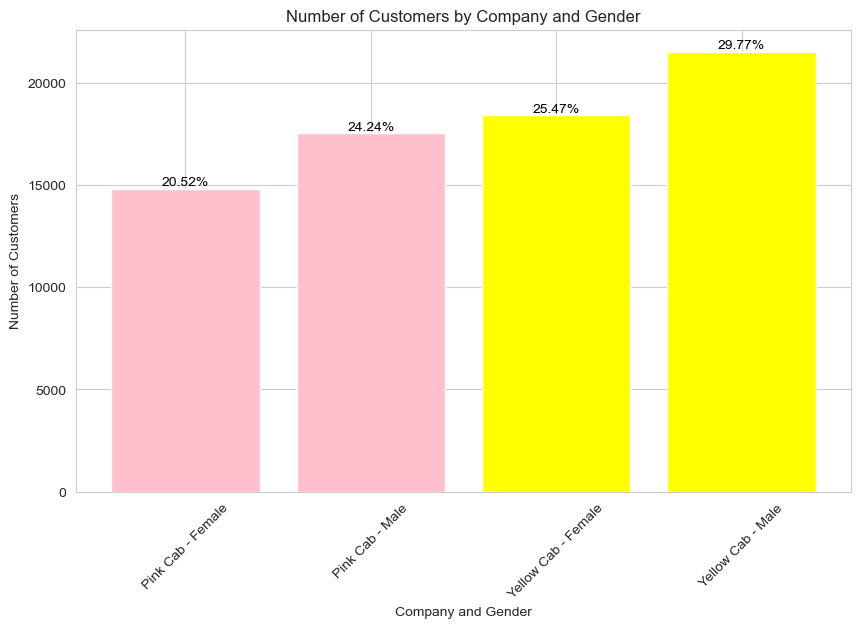

In [51]:
import matplotlib.pyplot as plt

# Grouping by Company and Gender and counting unique Customer IDs
customer_counts = df_new.groupby(['Company', 'Gender'])['Customer_ID'].nunique().reset_index()

# Visualization setup
color_map = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}
plt.figure(figsize=(10, 6))

# Plotting the bars
for index, row in customer_counts.iterrows():
    company, gender, count = row['Company'], row['Gender'], row['Customer_ID']
    label = f'{company} - {gender}'
    total_customers = customer_counts['Customer_ID'].sum()
    percentage = (count / total_customers) * 100
    plt.bar(label, count, color=color_map[company])
    plt.text(label, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Labeling the axes and title
plt.xlabel('Company and Gender')
plt.ylabel('Number of Customers')
plt.xticks(range(len(customer_counts)), [f'{row["Company"]} - {row["Gender"]}' for _, row in customer_counts.iterrows()], rotation=45)
plt.title('Number of Customers by Company and Gender')

# Display the plot
plt.show()

- **Comparing the two cab companies, it's noticeable that both have more users who are male.**
- **Furthermore, it's clear that the user base of the Yellow Cab company is larger.**

# 2.

<h3 style="color:blue">Pink Cab</h3>

In [52]:
# Calculating the number of female and male customers for the 'Pink Cab' company
female_customers_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Customer_ID'].nunique()
male_customers_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Customer_ID'].nunique()

print("Pink Cab Female Customers:", female_customers_pink)
print("Pink Cab Male Customers:", male_customers_pink)

# Calculating the total and mean profit for female and male customers of the 'Pink Cab' company
total_profit_female_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit'].sum()
total_profit_male_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit'].sum()

mean_profit_female_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit'].mean()
mean_profit_male_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit'].mean()

print("Pink Cab Female Total Profit:", total_profit_female_pink)
print("Pink Cab Male Total Profit:", total_profit_male_pink)
print("Pink Cab Female Mean Profit:", mean_profit_female_pink)
print("Pink Cab Male Mean Profit:", mean_profit_male_pink)

profits_female_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit']
profits_male_pink = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit']

# Assumptions
#############################################

# Normality
test_normality(profits_female_pink, profits_male_pink)

# Homogeneity of variance
test_variance_homogeneity(profits_female_pink, profits_male_pink)

# Mann-Whitney U test function
#############################################
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(profits_female_pink, profits_male_pink)

Pink Cab Female Customers: 14819
Pink Cab Male Customers: 17511
Pink Cab Female Total Profit: 2330532.691
Pink Cab Male Total Profit: 2976795.63
Pink Cab Female Mean Profit: 62.18070146744931
Pink Cab Male Mean Profit: 63.02630962715106
Sample 1: Test Statistic = 0.8629, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.8646, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 0.6671, p-value = 0.4141
The null hypothesis is not rejected, homogeneity of variances is satisfied.
Test Statistic = 879754157.5000, p-value = 0.1298
The null hypothesis is not rejected, indicating no statistically significant difference between the groups.


<h3 style="color:blue">Yellow Cab</h3>

In [53]:
# Calculating the number of female and male customers for the 'Yellow Cab' company
female_customers_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Customer_ID'].nunique()
male_customers_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Customer_ID'].nunique()

print("Yellow Cab Female Customers:", female_customers_yellow)
print("Yellow Cab Male Customers:", male_customers_yellow)

# Calculating the total and mean profit for female and male customers of the 'Yellow Cab' company
total_profit_female_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit'].sum()
total_profit_male_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit'].sum()

mean_profit_female_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit'].mean()
mean_profit_male_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit'].mean()

print("Yellow Cab Female Total Profit:", total_profit_female_yellow)
print("Yellow Cab Male Total Profit:", total_profit_male_yellow)
print("Yellow Cab Female Mean Profit:", mean_profit_female_yellow)
print("Yellow Cab Male Mean Profit:", mean_profit_male_yellow)

profits_female_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit']
profits_male_yellow = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit']

# Assumptions
#############################################

# Normality
test_normality(profits_female_yellow, profits_male_yellow)

# Homogeneity of variance
test_variance_homogeneity(profits_female_yellow, profits_male_yellow)

# Mann-Whitney U test function
#############################################
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(profits_female_yellow, profits_male_yellow)

Yellow Cab Female Customers: 18394
Yellow Cab Male Customers: 21502
Yellow Cab Female Total Profit: 18131417.6532
Yellow Cab Male Total Profit: 25888955.517599996
Yellow Cab Female Mean Profit: 156.30532459654972
Yellow Cab Male Mean Profit: 163.15094760935543
Sample 1: Test Statistic = 0.8349, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.8383, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 104.1823, p-value = 0.0000
The null hypothesis is rejected, homogeneity of variances is not satisfied.
Test Statistic = 9034571934.0000, p-value = 0.0000
The null hypothesis is rejected, indicating a statistically significant difference between the groups.


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Income of Cab Customers</h3>
</div>

Average Income for Pink Cab Customers: 15034.097618311165
Average Income for Yellow Cab Customers: 14983.896831762582


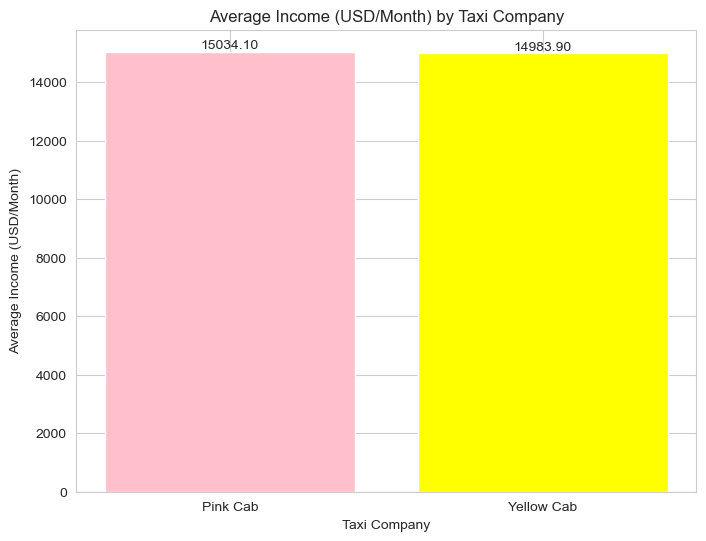

In [54]:
import matplotlib.pyplot as plt

# Calculating the mean income per customer
unique_customer_incomes = df_new.groupby('Customer_ID')['Income_(USD/Month)'].mean()

# Calculating the average income for customers of each taxi company
avg_income_pink_cab = df_new[df_new['Company'] == 'Pink Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean().mean()
avg_income_yellow_cab = df_new[df_new['Company'] == 'Yellow Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean().mean()

print("Average Income for Pink Cab Customers:", avg_income_pink_cab)
print("Average Income for Yellow Cab Customers:", avg_income_yellow_cab)

# Creating a bar chart to compare the average income for the two companies
taxi_companies = ['Pink Cab', 'Yellow Cab']
average_incomes = [avg_income_pink_cab, avg_income_yellow_cab]

plt.figure(figsize=(8, 6))
bars = plt.bar(taxi_companies, average_incomes, color=['pink', 'yellow'])
plt.xlabel('Taxi Company')
plt.ylabel('Average Income (USD/Month)')
plt.title('Average Income (USD/Month) by Taxi Company')

# Adding text labels to the bars
for bar, avg_income in zip(bars, average_incomes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{avg_income:.2f}', ha='center', va='bottom')

plt.show()

# 3.

In [55]:
# Performing a hypothesis test on income data for Pink Cab and Yellow Cab customers
income_pink_cab = df_new[df_new['Company'] == 'Pink Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()
income_yellow_cab = df_new[df_new['Company'] == 'Yellow Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()

# Assumptions
#############################################

# Testing for normality
test_normality(income_pink_cab, income_yellow_cab)

# Testing for homogeneity of variance
test_variance_homogeneity(income_pink_cab, income_yellow_cab)

# Mann-Whitney U test function
#############################################
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(income_pink_cab, income_yellow_cab)

Sample 1: Test Statistic = 0.9707, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.9702, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 0.0395, p-value = 0.8424
The null hypothesis is not rejected, homogeneity of variances is satisfied.
Test Statistic = 647299744.0000, p-value = 0.3928
The null hypothesis is not rejected, indicating no statistically significant difference between the groups.


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Distribution of Cab Users Among Companies Over the Years</h3>
</div>

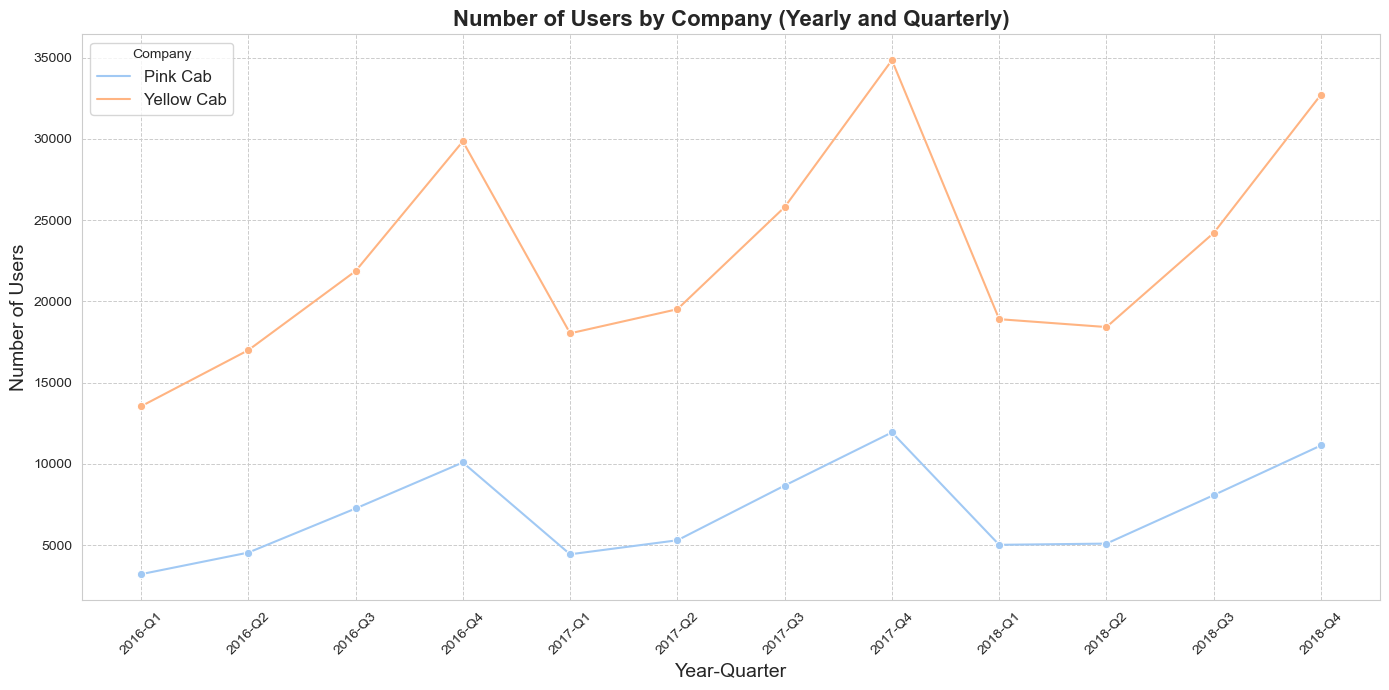

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting year and quarter from the Date_of_Travel column
df_new['Year'] = pd.to_datetime(df_new['Date_of_Travel']).dt.year
df_new['Quarter'] = pd.to_datetime(df_new['Date_of_Travel']).dt.quarter

# Grouping the data by year, quarter, and company
yearly_quarterly_data = df_new.groupby(['Year', 'Quarter', 'Company'])['Customer_ID'].count().unstack().fillna(0)

# Resetting index for better handling of data
yearly_quarterly_data.reset_index(inplace=True)

# Melting the data for seaborn compatibility
yearly_quarterly_melted = yearly_quarterly_data.melt(id_vars=['Year', 'Quarter'], var_name='Company', value_name='Customer_Count')

# Creating a new column for year and quarter combined
yearly_quarterly_melted['Year-Quarter'] = yearly_quarterly_melted['Year'].astype(str) + '-Q' + yearly_quarterly_melted['Quarter'].astype(str)

# Setting the color palette
sns.set_palette("pastel")

# Plotting the data using seaborn lineplot
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_quarterly_melted, x='Year-Quarter', y='Customer_Count', hue='Company', marker='o')

# Adding titles and labels
plt.title('Number of Users by Company (Yearly and Quarterly)', fontsize=16, fontweight='bold')
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Rotating x-ticks for better readability
plt.xticks(rotation=45)

# Displaying the legend
plt.legend(title='Company', loc='upper left', fontsize=12)

# Adding grid lines for better readability
plt.grid(True, linestyle='--', linewidth=0.7)

# Adjusting layout for better fit
plt.tight_layout()

# Displaying the plot
plt.show()

- Upon examining the graph, there is a noticeable rise in customer demand for cab usage from the first quarter to the fourth quarter in each of the years 2016, 2017, and 2018.

- The increasing demand for cab usage from the first quarter to the fourth quarter in each of the years 2016, 2017, and 2018 can be influenced by several factors, such as seasonal variations, economic factors, special events, holidays, urban population growth, and a preference for cabs during inclement weather conditions.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>The Impact of Loyal Customers and Champions on Profit in Yellow Cab and Pink Cab Companies</h3>
</div>

In [57]:
import datetime as dt

# Separating customers based on the company
###########################################
customers_pink_cab = df_new[df_new['Company'] == 'Pink Cab']
customers_yellow_cab = df_new[df_new['Company'] == 'Yellow Cab']

# Finding the maximum travel date
max_travel_date = df_new["Date_of_Travel"].max()
print(f"Maximum travel date: {max_travel_date}")

# Setting the analysis date to two days after the maximum travel date
analysis_date = dt.date(2019, 1, 2)
print(f"Analysis date: {analysis_date}")

Maximum travel date: 2018-12-31
Analysis date: 2019-01-02


### RFM - Pink Cab

In [58]:
from IPython.display import Image

# Calculating RFM values for Pink Cab customers
rfm_pink_cab = customers_pink_cab.groupby('Customer_ID').agg({
    'Date_of_Travel': lambda Date_of_Travel: (analysis_date - Date_of_Travel.max()).days,
    'Transaction_ID': lambda Transaction_ID: Transaction_ID.nunique(),
    'Price_Charged': lambda Price_Charged: Price_Charged.sum()
})

rfm_pink_cab.columns = ['recency', 'frequency', 'monetary']
print(rfm_pink_cab.head())
print(rfm_pink_cab.describe().T)

# Calculating RFM scores
rfm_pink_cab["recency_score"] = pd.qcut(rfm_pink_cab['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_pink_cab["frequency_score"] = pd.qcut(rfm_pink_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_pink_cab["monetary_score"] = pd.qcut(rfm_pink_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_pink_cab["RFM_SCORE"] = rfm_pink_cab['recency_score'].astype(str) + rfm_pink_cab['frequency_score'].astype(str)

# Creating and analyzing RFM segments
segment_mapping = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_pink_cab['segment'] = rfm_pink_cab['RFM_SCORE'].replace(segment_mapping, regex=True)
print(rfm_pink_cab.head())

# Displaying RFM segmentation image
url = "https://cdn.enhencer.com/website-assets/images/blog/AdvantagesAndInefficaciesOfRFMSegmentation1.png"
Image(url=url, width=600, height=400)

# Counting the number of 'Champions' and 'Loyal Customers' in Pink Cab
champions_loyal_customers_count = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | 
                                                (rfm_pink_cab['segment'] == 'champions')].shape[0]

print("Number of Loyal Customers and Champions:", champions_loyal_customers_count)

             recency  frequency  monetary
Customer_ID                              
1                388          4  2286.480
10               157          3  1001.490
100              439          4  1934.620
1000              72          6  2813.150
10001             33          1    28.650
              count    mean     std    min     25%     50%      75%      max
recency   32330.000 340.657 292.521  2.000  81.000 272.000  517.000 1096.000
frequency 32330.000   2.620   2.194  1.000   1.000   2.000    3.000   18.000
monetary  32330.000 814.360 762.878 15.600 294.532 543.455 1092.140 6568.900
             recency  frequency  monetary recency_score frequency_score monetary_score RFM_SCORE          segment
Customer_ID                                                                                                      
1                388          4  2286.480             2               4              5        24          at_risk
10               157          3  1001.490             4 

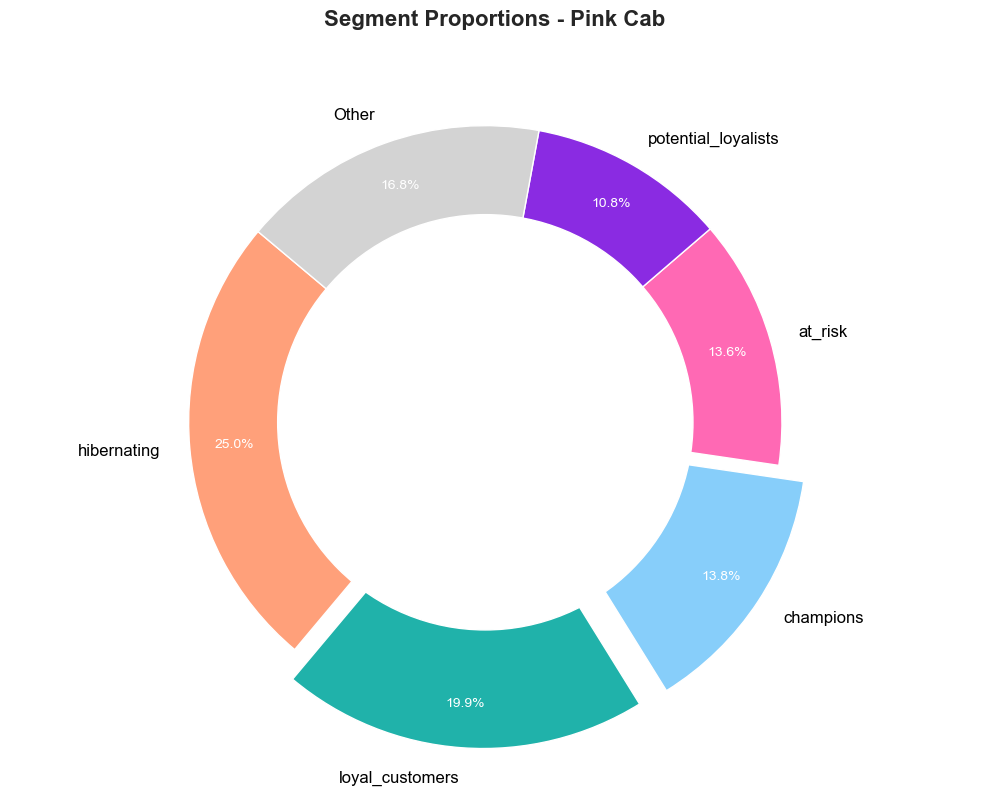

In [60]:
import matplotlib.pyplot as plt

# Calculating the proportion of each segment
segment_proportions = rfm_pink_cab['segment'].value_counts(normalize=True)

# Identifying the top 5 segments by proportion
top_5_segments = segment_proportions.nlargest(5).index.tolist()

# Calculating the proportion of other segments
proportion_other_segments = 1 - segment_proportions[top_5_segments].sum()
segment_proportions['Other'] = proportion_other_segments

# Defining a new color scheme for the pie chart
new_color_palette = ['#FFA07A', '#20B2AA', '#87CEFA', '#FF69B4', '#8A2BE2', '#D3D3D3']

# Creating an explode effect for 'loyal_customers' and 'champions'
explode_effect = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions.index]

# Filtering the proportions to include the top segments and "Other"
filtered_proportions = segment_proportions[top_5_segments + ['Other']]
filtered_explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions.index]

# Generating the pie chart with a new design
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    filtered_proportions, 
    labels=filtered_proportions.index, 
    autopct='%1.1f%%', 
    shadow=False, 
    colors=new_color_palette, 
    startangle=140, 
    explode=filtered_explode,
    pctdistance=0.85
)

# Formatting the labels and autopct text
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Drawing a circle at the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding a title to the pie chart
plt.title("Segment Proportions - Pink Cab", loc="center", y=1.08, fontsize=16, fontweight='bold')

# Displaying the pie chart
plt.tight_layout()
plt.show()

### RFM - Yellow Cab

In [61]:
# Calculating RFM values for Yellow Cab customers
rfm_yellow_cab = customers_yellow_cab.groupby('Customer_ID').agg({
    'Date_of_Travel': lambda date: (analysis_date - date.max()).days,
    'Transaction_ID': lambda trans_id: trans_id.nunique(),
    'Price_Charged': lambda price: price.sum()
})

rfm_yellow_cab.columns = ['recency', 'frequency', 'monetary']
print(rfm_yellow_cab.head())
print(rfm_yellow_cab.describe().T)

# Calculating RFM scores
rfm_yellow_cab["recency_score"] = pd.qcut(rfm_yellow_cab['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_yellow_cab["frequency_score"] = pd.qcut(rfm_yellow_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_yellow_cab["monetary_score"] = pd.qcut(rfm_yellow_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_yellow_cab["RFM_SCORE"] = rfm_yellow_cab['recency_score'].astype(str) + rfm_yellow_cab['frequency_score'].astype(str)

# Creating and analyzing RFM segments using the same segment mapping as Pink Cab
rfm_yellow_cab['segment'] = rfm_yellow_cab['RFM_SCORE'].replace(segment_mapping, regex=True)
print(rfm_yellow_cab.head())

# Counting the number of 'Champions' and 'Loyal Customers' in Yellow Cab
champions_loyal_customers_count_yellow = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | 
                                                        (rfm_yellow_cab['segment'] == 'champions')].shape[0]

print("Number of Loyal Customers and Champions in Yellow Cab:", champions_loyal_customers_count_yellow)


             recency  frequency  monetary
Customer_ID                              
1                 17         25 15203.650
10                11         21 11906.240
100               14         35 21660.870
1000              39         27 14081.770
10000            365          2   963.070
              count     mean      std    min     25%      50%      75%       max
recency   39896.000  262.796  279.443  2.000  40.000  133.000  425.000  1096.000
frequency 39896.000    6.885    8.183  1.000   1.000    3.000   10.000    47.000
monetary  39896.000 3154.549 4602.075 24.790 556.057 1260.965 3895.115 32351.360
             recency  frequency  monetary recency_score frequency_score monetary_score RFM_SCORE          segment
Customer_ID                                                                                                      
1                 17         25 15203.650             5               5              5        55        champions
10                11         21 11906.24

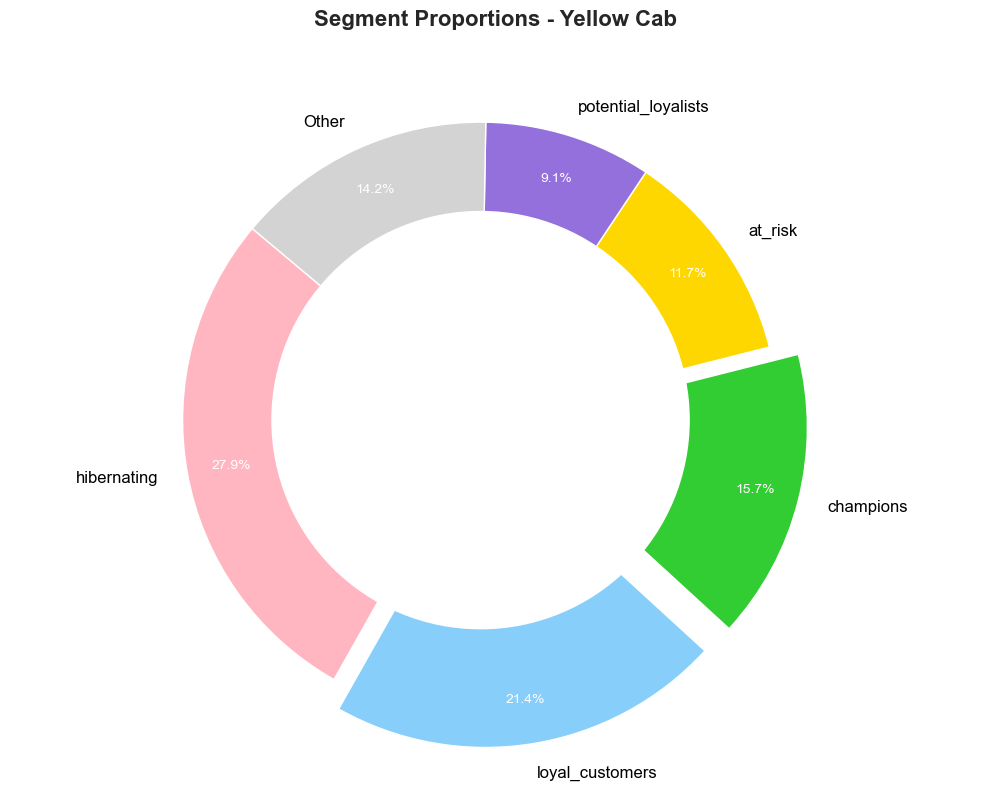

In [62]:
import matplotlib.pyplot as plt

# Calculating the proportion of each segment for Yellow Cab
segment_proportions_yellow = rfm_yellow_cab['segment'].value_counts(normalize=True)

# Identifying the top 5 segments by proportion
top_5_segments_yellow = segment_proportions_yellow.nlargest(5).index.tolist()

# Calculating the proportion of other segments
proportion_other_segments_yellow = 1 - segment_proportions_yellow[top_5_segments_yellow].sum()
segment_proportions_yellow['Other'] = proportion_other_segments_yellow

# Defining a new color scheme for the pie chart
color_palette_yellow = ['#FFB6C1', '#87CEFA', '#32CD32', '#FFD700', '#9370DB', '#D3D3D3']

# Creating an explode effect for 'loyal_customers' and 'champions'
explode_effect_yellow = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions_yellow.index]

# Filtering the proportions to include the top segments and "Other"
filtered_proportions_yellow = segment_proportions_yellow[top_5_segments_yellow + ['Other']]
filtered_explode_yellow = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions_yellow.index]

# Generating the pie chart with a new design
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    filtered_proportions_yellow, 
    labels=filtered_proportions_yellow.index, 
    autopct='%1.1f%%', 
    shadow=False, 
    colors=color_palette_yellow, 
    startangle=140, 
    explode=filtered_explode_yellow,
    pctdistance=0.85
)

# Formatting the labels and autopct text
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Drawing a circle at the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding a title to the pie chart
plt.title("Segment Proportions - Yellow Cab", loc="center", y=1.08, fontsize=16, fontweight='bold')

# Displaying the pie chart
plt.tight_layout()
plt.show()

# 4.

In [68]:
# Assuming pink_cab_customers and yellow_cab_customers are defined correctly elsewhere in your script
customers_pink_cab = df_new[df_new['Company'] == 'Pink Cab']
customers_yellow_cab = df_new[df_new['Company'] == 'Yellow Cab']

# Adding total profit for Pink Cab and Yellow Cab customers to the RFM tables
rfm_pink_cab['Total_Profit'] = customers_pink_cab.groupby('Customer_ID')['Profit'].sum()
rfm_yellow_cab['Total_Profit'] = customers_yellow_cab.groupby('Customer_ID')['Profit'].sum()

# Filtering loyal customers and champions for both Pink Cab and Yellow Cab
profits_loyal_champions_pink = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | 
                                             (rfm_pink_cab['segment'] == 'champions')]['Total_Profit']
profits_loyal_champions_yellow = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | 
                                                 (rfm_yellow_cab['segment'] == 'champions')]['Total_Profit']

# Testing for normality
test_normality(profits_loyal_champions_pink, profits_loyal_champions_yellow)

# Testing for homogeneity of variance
test_variance_homogeneity(profits_loyal_champions_pink, profits_loyal_champions_yellow)

# Mann-Whitney U test function
#############################################
def perform_mann_whitney_u_test(sample1, sample2, significance_level=0.05):
    test_statistic, p_value = mannwhitneyu(sample1, sample2, alternative='two-sided')
    if p_value < significance_level:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is rejected, indicating a statistically significant difference between the groups.')
    else:
        print(f'Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f}')
        print('The null hypothesis is not rejected, indicating no statistically significant difference between the groups.')

# Performing the Mann-Whitney U test
perform_mann_whitney_u_test(profits_loyal_champions_pink, profits_loyal_champions_yellow)

# Summing the total profit for loyal customers and champions for both companies
total_profit_pink = profits_loyal_champions_pink.sum()
total_profit_yellow = profits_loyal_champions_yellow.sum()

# Comparing the total profits
if total_profit_pink > total_profit_yellow:
    print("Pink Cab's loyal customers and champions generate more profit than Yellow Cab's.")
elif total_profit_pink < total_profit_yellow:
    print("Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.")
else:
    print("Pink Cab's loyal customers and champions generate the same profit as Yellow Cab's.")

Sample 1: Test Statistic = 0.9051, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 1.
Sample 2: Test Statistic = 0.6473, p-value = 0.0000
The null hypothesis is rejected, normality assumption is not met for sample 2.
Test Statistic = 3236.7792, p-value = 0.0000
The null hypothesis is rejected, homogeneity of variances is not satisfied.
Test Statistic = 13849021.5000, p-value = 0.0000
The null hypothesis is rejected, indicating a statistically significant difference between the groups.
Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.


- The null hypothesis (H0) is rejected, indicating a discernible difference between them.

With the insights gained from these RFM analyses, targeted marketing strategies and campaigns can be designed to effectively engage each customer segment. This includes personalized communication, tailored pricing strategies, loyalty programs, and enhancements to overall customer experience.-  